#### Multivariate Time Series with RNN

Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [45]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#### Import the Energy Dataset

In [46]:
df = pd.read_csv("./UDEMY_TSA_FINAL/MultiVariate-RNN-with-TensorFlow-and-Keras-master/DATA/energydata_complete.csv",
                index_col = "date",
                infer_datetime_format = True)
df = df[["Appliances", "lights"]]
df.head()

,Appliances,lights
date,,
2016-01-11 17:00:00,60,30
2016-01-11 17:10:00,60,30
2016-01-11 17:20:00,50,30
2016-01-11 17:30:00,50,40
2016-01-11 17:40:00,60,40


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Appliances  19735 non-null  int64
 1   lights      19735 non-null  int64
dtypes: int64(2)
memory usage: 462.5+ KB


#### Plot the Appliances and Lights

<AxesSubplot:xlabel='date'>

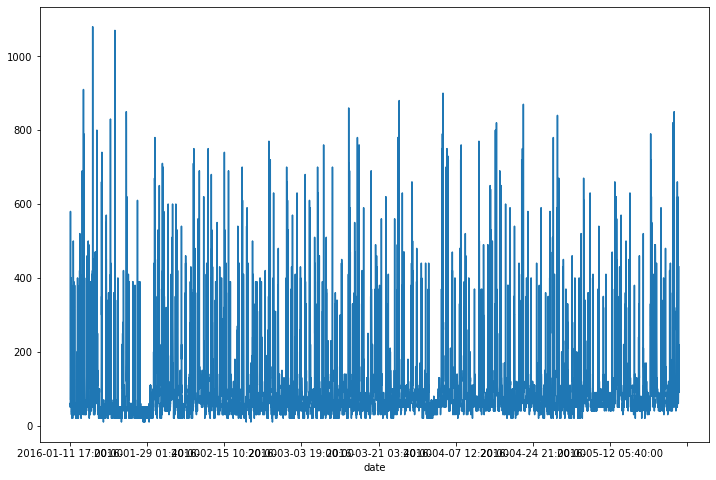

In [48]:
df["Appliances"].plot(figsize = (12, 8))

<AxesSubplot:xlabel='date'>

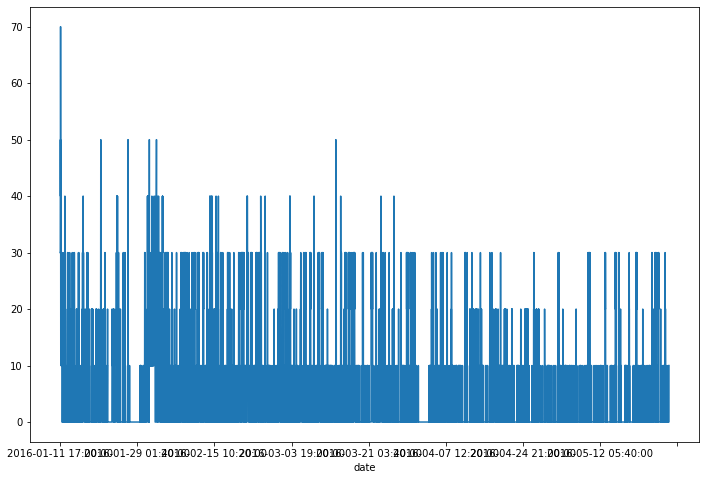

In [49]:
df["lights"].plot(figsize = (12, 8))

#### Train Test Split

In [50]:
len(df)

19735

In [51]:
df.head(3)

,Appliances,lights
date,,
2016-01-11 17:00:00,60,30
2016-01-11 17:10:00,60,30
2016-01-11 17:20:00,50,30


In [52]:
df.tail(3)

,Appliances,lights
date,,
2016-05-27 17:40:00,270,10
2016-05-27 17:50:00,420,10
2016-05-27 18:00:00,430,10


Let's imagine we want to predict just 24 hours into the future, we don't need 3 months of data for that, so let's save some training time and only select the last months data.

In [53]:
df = df.loc['2016-05-01':]

#### Round Off the Data

In [99]:
df = df.round(2)
df.shape

(3853, 2)

In [55]:
# How many rows per day? We know its every 10 min
24*60/10

144.0

In [56]:
test_days = 2
test_ind = test_days * 144
test_ind

288

In [57]:
# Notice the minus sign in our indexing

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [58]:
train.tail(2)

,Appliances,lights
date,,
2016-05-25 17:50:00,90,0
2016-05-25 18:00:00,100,0


In [59]:
test.head(2)

,Appliances,lights
date,,
2016-05-25 18:10:00,170,0
2016-05-25 18:20:00,310,0


#### Scale Data

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [61]:
scaler.fit(train)

MinMaxScaler()

In [62]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

In [63]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [64]:
# define generator
length = 144 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [65]:
len(scaled_train)

3565

In [66]:
len(generator)

3421

In [67]:
len(scaled_train) - len(generator)

144

In [68]:
# What does the first batch look like?
X,y = generator[0]

In [69]:
# print(f'Given the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

#### Create the RNN Model

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [71]:
scaled_train.shape

(3565, 2)

In [72]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,
               input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               41200     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________


In [74]:
### EarlyStopping

In [79]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5)
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test, 
                                           length=length, 
                                           batch_size=batch_size)

In [80]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10
   3/3421 [..............................] - ETA: 2:01 - loss: 7.0993e-04

C:\Users\CHRIST~1\AppData\Local\Temp/ipykernel_27124/687208369.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=10,


3421/3421 [==============================] - 107s 31ms/step - loss: 0.0098 - val_loss: 0.0159
Epoch 2/10
3421/3421 [==============================] - 107s 31ms/step - loss: 0.0097 - val_loss: 0.0147
Epoch 3/10
3421/3421 [==============================] - 104s 31ms/step - loss: 0.0095 - val_loss: 0.0157
Epoch 4/10
3421/3421 [==============================] - 106s 31ms/step - loss: 0.0096 - val_loss: 0.0148
Epoch 5/10
3421/3421 [==============================] - 106s 31ms/step - loss: 0.0104 - val_loss: 0.0166
Epoch 6/10
3421/3421 [==============================] - 107s 31ms/step - loss: 0.0093 - val_loss: 0.0153
Epoch 7/10
3421/3421 [==============================] - 107s 31ms/step - loss: 0.0093 - val_loss: 0.0156


In [77]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

#### Plot the loss and val_loss

<AxesSubplot:>

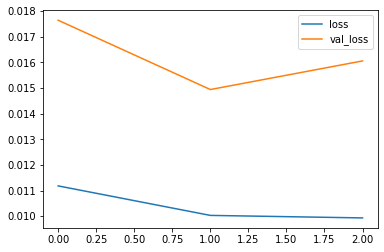

In [78]:
losses = pd.DataFrame(model.history.history)
losses.plot()

#### Evaluate on Test Data

In [86]:
first_eval_batch = scaled_train[-length:]
# first_eval_batch

#### Reshape [[]] --> [[[]]]

In [87]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))
# first_eval_batch

#### Model Predictions

In [90]:
model.predict(first_eval_batch) #Prediction for the first eval batch

1/1 [==============================] - 0s 32ms/step


array([[0.1125842, 0.032395 ]], dtype=float32)

In [91]:
scaled_test[0] #Actual for the first eval batch

array([0.19480519, 0.        ])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [92]:
n_features = scaled_train.shape[1]
n_features

2

In [93]:
test_predictions = []

In [95]:
first_eval_batch = scaled_train[-length:]
# first_eval_batch

In [97]:
current_batch = first_eval_batch.reshape((1, length, n_features))
# current_batch

In [98]:
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store pred
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [101]:
# test_predictions

In [103]:
# scaled_test

In [104]:
### Inverse Transformations and Compare

In [105]:
true_predictions = scaler.inverse_transform(test_predictions)

In [108]:
test.head()

,Appliances,lights
date,,
2016-05-25 18:10:00,170,0
2016-05-25 18:20:00,310,0
2016-05-25 18:30:00,120,0
2016-05-25 18:40:00,120,0
2016-05-25 18:50:00,120,0


In [110]:
test.shape

(288, 2)

In [109]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)
true_predictions.head()

,Appliances,lights
0,106.689831,0.971850
1,108.198568,1.629459
2,107.626640,2.198579
3,106.301331,2.588333
4,104.524518,2.898829


In [111]:
true_predictions.shape

(288, 2)

## EXTRA:
#### Our Saved Model

In [112]:
from tensorflow.keras.models import load_model

In [113]:
model.save("multivariate.h5")